# Chapter 5 - AutoRegressive Integrated Moving Average (ARIMA) Models

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima_process import ArmaProcess
from pmdarima.arima import CHTest


import warnings
warnings.filterwarnings('ignore')

## 5.24 Table B.10 contains 7 years of monthly data on the number of airline miles flown in the United Kingdom. 
This is seasonal data.

    a. Using the first 6 years of data, develop an appropriate ARIMA model and a procedure for these data.
    
    b. Explain how prediction intervals would be computed.
    
    c. Make one-step-ahead forecasts of the last 12 months. Determine the forecast errors. How well did your procedure work in forecasting the new data?

In [3]:
# Raw data as alternating Month and Miles values
raw_data = [
    ("Jan-1964", 7.269), ("Feb-1964", 6.775), ("Mar-1964", 7.819), ("Apr-1964", 8.371),
    ("May-1964", 9.069), ("Jun-1964", 10.248), ("Jul-1964", 11.030), ("Aug-1964", 10.882),
    ("Sep-1964", 10.333), ("Oct-1964", 9.109), ("Nov-1964", 7.685), ("Dec-1964", 7.682),
    ("Jan-1965", 8.350), ("Feb-1965", 7.829), ("Mar-1965", 8.829), ("Apr-1965", 9.948),
    ("May-1965", 10.638), ("Jun-1965", 11.253), ("Jul-1965", 11.424), ("Aug-1965", 11.391),
    ("Sep-1965", 10.665), ("Oct-1965", 9.396), ("Nov-1965", 7.775), ("Dec-1965", 7.933),
    ("Jan-1966", 8.186), ("Feb-1966", 7.444), ("Mar-1966", 8.484), ("Apr-1966", 9.864),
    ("May-1966", 10.252), ("Jun-1966", 12.282), ("Jul-1966", 11.637), ("Aug-1966", 11.577),
    ("Sep-1966", 12.417), ("Oct-1966", 9.637), ("Nov-1966", 8.094), ("Dec-1966", 9.280),
    ("Jan-1967", 8.334), ("Feb-1967", 7.899), ("Mar-1967", 9.994), ("Apr-1967", 10.078),
    ("May-1967", 10.801), ("Jun-1967", 12.953), ("Jul-1967", 12.222), ("Aug-1967", 12.246),
    ("Sep-1967", 13.281), ("Oct-1967", 10.366), ("Nov-1967", 8.730), ("Dec-1967", 9.614),
    ("Jan-1968", 8.639), ("Feb-1968", 8.772), ("Mar-1968", 10.894), ("Apr-1968", 10.455),
    ("May-1968", 11.179), ("Jun-1968", 10.588), ("Jul-1968", 10.794), ("Aug-1968", 12.770),
    ("Sep-1968", 13.812), ("Oct-1968", 10.857), ("Nov-1968", 9.290), ("Dec-1968", 10.925),
    ("Jan-1969", 9.491), ("Feb-1969", 8.919), ("Mar-1969", 11.607), ("Apr-1969", 8.852),
    ("May-1969", 12.537), ("Jun-1969", 14.759), ("Jul-1969", 13.667), ("Aug-1969", 13.731),
    ("Sep-1969", 15.110), ("Oct-1969", 12.185), ("Nov-1969", 10.645), ("Dec-1969", 12.161),
    ("Jan-1970", 10.840), ("Feb-1970", 10.436), ("Mar-1970", 13.589), ("Apr-1970", 13.402),
    ("May-1970", 13.103), ("Jun-1970", 14.933), ("Jul-1970", 14.147), ("Aug-1970", 14.057),
    ("Sep-1970", 16.234), ("Oct-1970", 12.389), ("Nov-1970", 11.594), ("Dec-1970", 12.772),
]

# Convert to DataFrame
df_air_miles = pd.DataFrame(raw_data, columns=['Month', 'Miles'])

# Convert 'Month' column to datetime format and set as index
df_air_miles['Month'] = pd.to_datetime(df_air_miles['Month'], format='%b-%Y')
df_air_miles.set_index('Month', inplace=True)

# Display the first rows
df_air_miles.head()

,Miles
Month,
1964-01-01,7.269
1964-02-01,6.775
1964-03-01,7.819
1964-04-01,8.371
1964-05-01,9.069


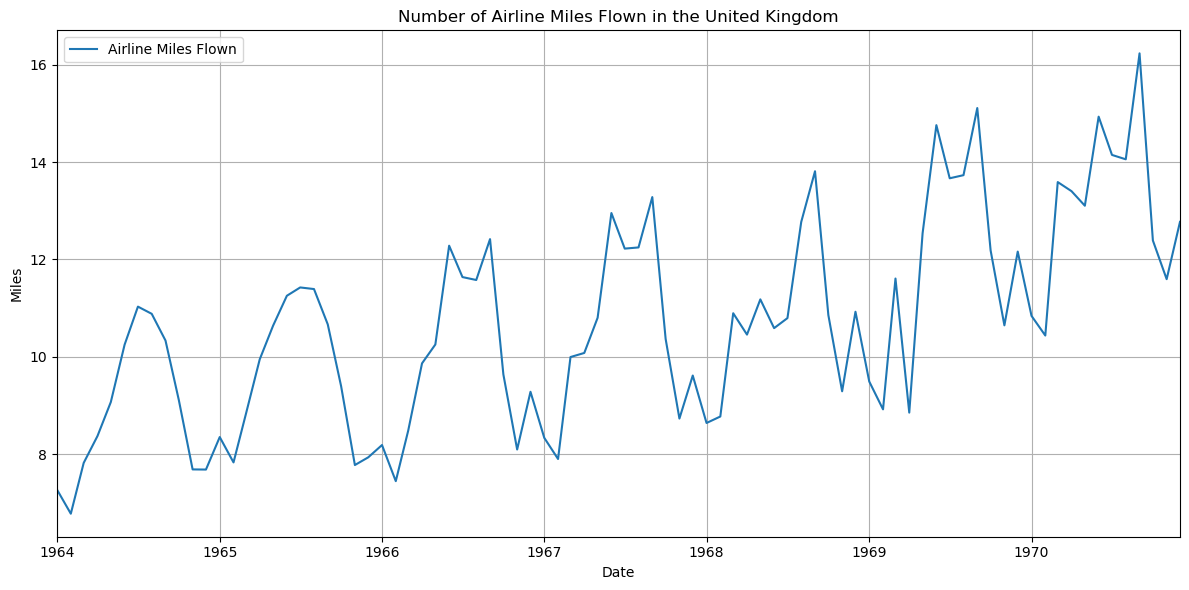

In [4]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

plt.plot(df_air_miles.index, df_air_miles['Miles'], label='Airline Miles Flown')     

plt.title('Number of Airline Miles Flown in the United Kingdom')                      
plt.xlabel('Date')                                        
plt.ylabel('Miles')  
plt.xlim(pd.to_datetime('1964-01-01'), pd.to_datetime('1970-12-01'))
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

In [5]:
air_series_0 = df_air_miles['Miles']

In [6]:
def determine_nonseasonal_d(series, max_d=2, alpha=0.05):
    
    for d in range(0, max_d + 1):
        if d == 0:
            tested_series = series.dropna()
        else:
            tested_series = series.diff(d).dropna()
        
        adf_result = adfuller(tested_series)
        p_value = adf_result[1]
        
        print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")
        
        if p_value < alpha:
            print(f"-> Series is stationary after differencing d = {d}")
            return d
    
    print("-> Series is non-stationary even after maximum differencing.")
    return max_d
    

d = determine_nonseasonal_d(air_series_0)
print(f"\nFinal non-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = 0.8785, p-value = 0.9928
d = 1 | ADF Statistic = -7.8054, p-value = 0.0000
-> Series is stationary after differencing d = 1

Final non-seasonal differencing term (d): 1


In [7]:
def determine_seasonal_d(serie, seasonal_period=12, max_D=2, alpha=0.05):
    
    for D in range(0, max_D + 1):
        if D == 0:
            tested_series = serie.dropna()
        else:
            tested_series = serie.diff(seasonal_period * D).dropna()

        adf_result = adfuller(tested_series)
        p_value = adf_result[1]

        print(f"D = {D} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")
        
        if p_value < alpha:
            print(f"-> Series is stationary after seasonal differencing D = {D}")
            return D

    print("\n-> Series is non-stationary even after maximum seasonal differencing.")
    return max_D

D = determine_seasonal_d(air_series_0, seasonal_period=12)
print(f"\nFinal seasonal differencing term (D): {D}")

D = 0 | ADF Statistic = 0.8785, p-value = 0.9928
D = 1 | ADF Statistic = -3.3671, p-value = 0.0121
-> Series is stationary after seasonal differencing D = 1

Final seasonal differencing term (D): 1


    D = 1

In [8]:
# Split the data
train = df_air_miles[df_air_miles.index.year < 1970]     # All data before 1970
test = df_air_miles[df_air_miles.index.year == 1970]     # All data in 1970

# Show the results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
train.tail(), print(), test.head()

Train shape: (72, 1)
Test shape: (12, 1)




(             Miles
 Month             
 1969-08-01  13.731
 1969-09-01  15.110
 1969-10-01  12.185
 1969-11-01  10.645
 1969-12-01  12.161,
 None,
              Miles
 Month             
 1970-01-01  10.840
 1970-02-01  10.436
 1970-03-01  13.589
 1970-04-01  13.402
 1970-05-01  13.103)

In [9]:
air_series = train['Miles']

In [10]:
def determine_nonseasonal_d(series, max_d=2, alpha=0.05):
    
    for d in range(0, max_d + 1):
        if d == 0:
            tested_series = series.dropna()
        else:
            tested_series = series.diff(d).dropna()
        
        adf_result = adfuller(tested_series)
        p_value = adf_result[1]
        
        print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")
        
        if p_value < alpha:
            print(f"-> Series is stationary after differencing d = {d}")
            return d
    
    print("-> Series is non-stationary even after maximum differencing.")
    return max_d
    

d = determine_nonseasonal_d(air_series)
print(f"\nFinal non-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = 0.2847, p-value = 0.9766
d = 1 | ADF Statistic = -4.0768, p-value = 0.0011
-> Series is stationary after differencing d = 1

Final non-seasonal differencing term (d): 1


In [11]:
def determine_seasonal_d(serie, seasonal_period=12, max_D=2, alpha=0.05):
    
    for D in range(0, max_D + 1):
        if D == 0:
            tested_series = serie.dropna()
        else:
            tested_series = serie.diff(seasonal_period * D).dropna()

        adf_result = adfuller(tested_series)
        p_value = adf_result[1]

        print(f"D = {D} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")
        
        if p_value < alpha:
            print(f"-> Series is stationary after seasonal differencing D = {D}")
            return D

    print("\n-> Series is non-stationary even after maximum seasonal differencing.")
    return max_D

D = determine_seasonal_d(air_series, seasonal_period=12)
print(f"\nFinal seasonal differencing term (D): {D}")

D = 0 | ADF Statistic = 0.2847, p-value = 0.9766
D = 1 | ADF Statistic = -3.1328, p-value = 0.0242
-> Series is stationary after seasonal differencing D = 1

Final seasonal differencing term (D): 1


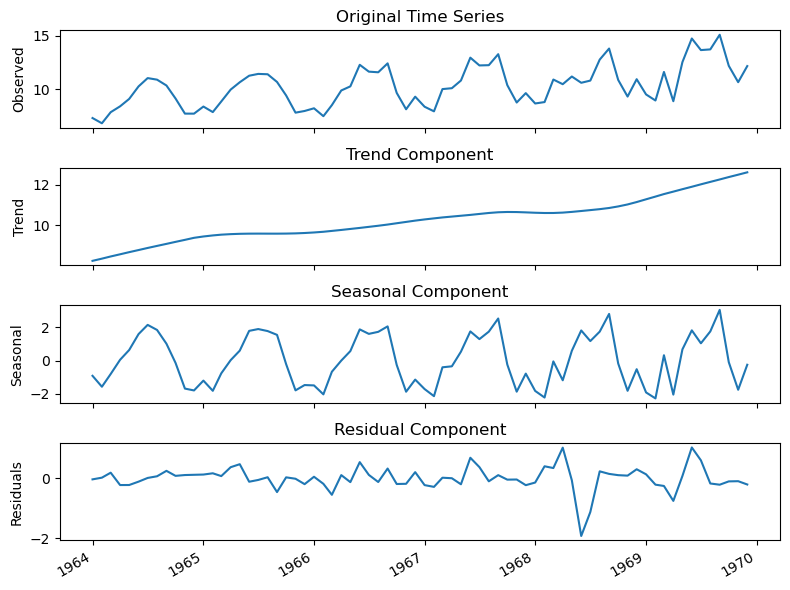

In [12]:
decom_air = STL(air_series, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8,6))

ax1.plot(decom_air.observed)
ax1.set_ylabel('Observed')
ax1.set_title("Original Time Series")

ax2.plot(decom_air.trend)
ax2.set_ylabel('Trend')
ax2.set_title("Trend Component")

ax3.plot(decom_air.seasonal)
ax3.set_ylabel('Seasonal')
ax3.set_title("Seasonal Component")

ax4.plot(decom_air.resid)
ax4.set_ylabel('Residuals')
ax4.set_title("Residual Component")

fig.autofmt_xdate()
plt.tight_layout()
plt.show();

In [13]:
# Perform a full search over the same grid as your manual SARIMAX model
auto_model = pm.auto_arima(
    air_series,                 # The time series data
    seasonal=True,              # Enable seasonal component
    m=12,                       # 12 months (seasonal period)
    d=1,                        # Set differencing 
    D=1,                        # Set seasonal differencing
    start_p=0, max_p=3,         # p 
    start_q=0, max_q=3,         # q 
    start_P=0, max_P=3,         # P 
    start_Q=0, max_Q=3,         # Q 
    stepwise=False,             # Disable stepwise search (enable full grid search)
    trace=True,                 # Print model search progress
    error_action='ignore',      # Ignore errors and continue
    suppress_warnings=True,     # Suppress convergence warnings
    information_criterion='aic' # Use AIC to choose the best model
)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=166.902, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=165.608, Time=0.04 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=167.000, Time=0.16 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=168.786, Time=0.51 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=165.333, Time=0.03 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=167.328, Time=0.24 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=168.914, Time=0.19 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=inf, Time=2.99 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=167.321, Time=0.08 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=170.534, Time=0.64 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=172.534, Time=1.32 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=168.572, Time=0.49 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=170.534, Time=2.50 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=172.534, Time=1.31 sec
 ARIMA(0,1,1)(0,1,

In [14]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


P_ns, Q_ns = [list(range(4))]*2          # Define search ranges for non-seasonal parameters (p, q): each from 0 to 3
P_s, Q_s = [list(range(4))]*2             # Define search ranges for seasonal parameters (P, Q): each from 0 to 3
d = 1
D = 1
S = 12

total = (P_ns[-1] + 1) * (Q_ns[-1] + 1) * (P_s[-1] + 1) * (Q_s[-1]+ 1)
print(f'Total number of models: {total}')

vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

score = {}                                     # Dictionary to store model evaluation metrics

for i, (p, d, q, P, D, Q) in enumerate(vals):  # Iterate over all parameter combinations
    if i % 15 == 0:                            # Print progress every 15 models
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

    m = SARIMAX(air_series,                    # Define SARIMA model with current parameter set
                order=(p,d,q), 
                seasonal_order=(P, D, Q, S),   # Particular case m = 30
                enforce_stationarity=False)    # Allow non-stationary models for broader search

    res = m.fit(disp=0, low_memory=True)       # Fit the model silently

    score[i] = {                               # Store model results and evaluation metrics
        'non-seasonal order': (p, d, q),      
        'seasonal order': (P, D, Q),
        'AIC': res.aic,                        # Akaike Information Criterion
        'AICc': res.aicc,                      # Corrected AIC
        'model': res                           # Fitted model object
    }
print()

pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

Total number of models: 256
Running model #0 using SARIMA(0,1,0)(0,1,0,12)
Running model #15 using SARIMA(0,1,0)(3,1,3,12)
Running model #30 using SARIMA(0,1,1)(3,1,2,12)
Running model #45 using SARIMA(0,1,2)(3,1,1,12)
Running model #60 using SARIMA(0,1,3)(3,1,0,12)
Running model #75 using SARIMA(1,1,0)(2,1,3,12)
Running model #90 using SARIMA(1,1,1)(2,1,2,12)
Running model #105 using SARIMA(1,1,2)(2,1,1,12)
Running model #120 using SARIMA(1,1,3)(2,1,0,12)
Running model #135 using SARIMA(2,1,0)(1,1,3,12)
Running model #150 using SARIMA(2,1,1)(1,1,2,12)
Running model #165 using SARIMA(2,1,2)(1,1,1,12)
Running model #180 using SARIMA(2,1,3)(1,1,0,12)
Running model #195 using SARIMA(3,1,0)(0,1,3,12)
Running model #210 using SARIMA(3,1,1)(0,1,2,12)
Running model #225 using SARIMA(3,1,2)(0,1,1,12)
Running model #240 using SARIMA(3,1,3)(0,1,0,12)
Running model #255 using SARIMA(3,1,3)(3,1,3,12)



,index,non-seasonal order,seasonal order,AIC,AICc,model
0,237,"(3, 1, 2)","(3, 1, 1)",66.78772,91.232165,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,55,"(0, 1, 3)","(1, 1, 3)",68.988281,83.388281,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,115,"(1, 1, 3)","(0, 1, 3)",69.483636,83.883636,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,247,"(3, 1, 3)","(1, 1, 3)",69.87546,107.589746,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,127,"(1, 1, 3)","(3, 1, 3)",69.931237,107.645523,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


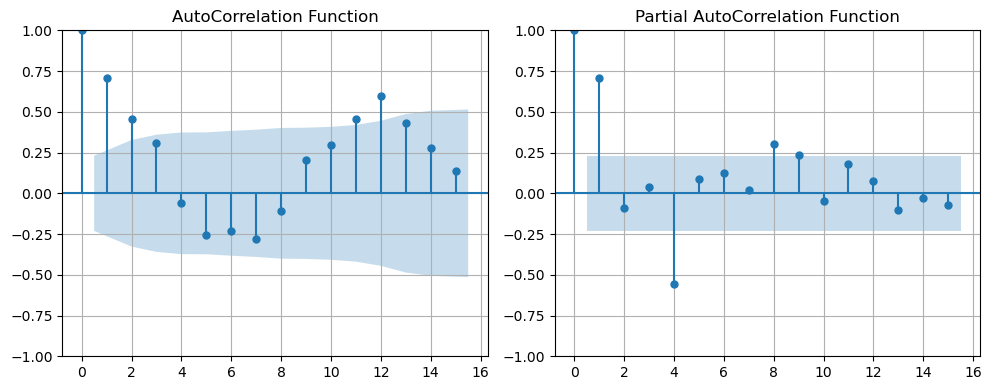

In [15]:
# Create a 1x2 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

# Interest Rate Data
plot_acf(air_series, ax=axes[0], lags=15)
axes[0].set_title("AutoCorrelation Function", fontsize=12)
axes[0].grid(True)

# Simulated Random Walk Data
plot_pacf(air_series, ax=axes[1], lags=15)
axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()

**ACF (Left Plot)**

    seasonal = 12
    q = 2
    Q = 1 (spike near lag 12)

**PACF (Right Plot)**

    p = 1 or 2
    P = 1 (seasonality around lag 12)

**Chosen model:** (3,1,2)(3,1,1)[12]

In [16]:
# Define the SARIMA(3,1,2)(3,1,1)[12] model
model_312 = SARIMAX(air_series,                          # Time series data
                    order=(3, 1, 2),                     # Non-seasonal order (p,d,q)
                    seasonal_order=(3, 1, 1, 12),        # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)          # Allow non-stationary behavior

# Fit the model
model_fit_312 = model_312.fit()

# Display summary of the model
print(model_fit_312.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Miles   No. Observations:                   72
Model:             SARIMAX(3, 1, 2)x(3, 1, [1], 12)   Log Likelihood                 -23.394
Date:                              Mon, 07 Apr 2025   AIC                             66.788
Time:                                      11:12:24   BIC                             76.745
Sample:                                  01-01-1964   HQIC                            68.731
                                       - 12-01-1969                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1939      0.254      0.763      0.445      -0.304       0.692
ar.L2         -0.22

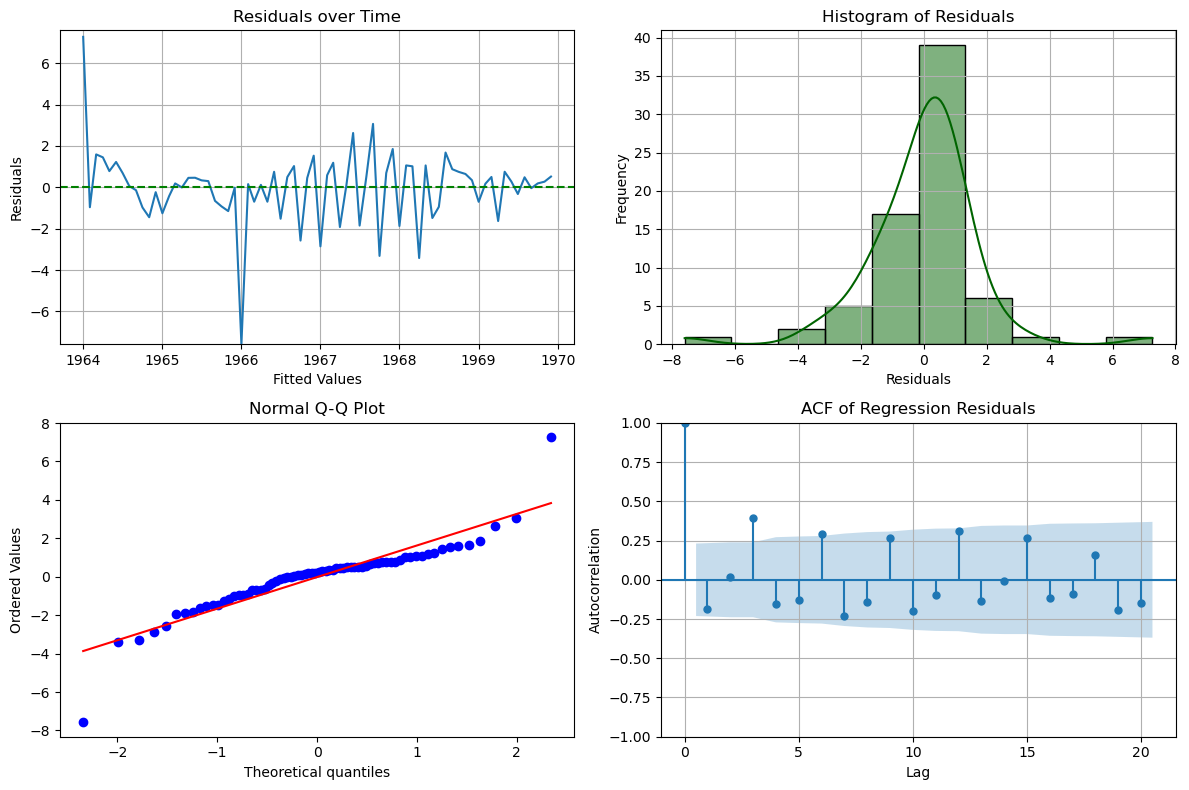

In [17]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_312.resid  

# Diagnostic plots for the model, including residuals and other model checks
#model_fit.plot_diagnostics(figsize=(10, 8));  

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Standardized Residuals
axes[0, 0].plot(residuals)
axes[0, 0].axhline(y=0, color='green', linestyle='--')          
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals over Time')
max_abs = abs(residuals).max()                     # Get max absolute residual
axes[0, 0].set_ylim(-max_abs, max_abs)             # Set symmetric limits
axes[0, 0].grid(True)

# 2. Histogram of Residuals
sns.histplot(residuals, bins=10, edgecolor='black', color='darkgreen', kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True)

# 3. Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Normal Q-Q Plot')
plt.grid(True)

# 4. Correlogram (ACF)
plot_acf(residuals, lags=20, ax=axes[1, 1])                    
axes[1, 1].set_title('ACF of Regression Residuals')
axes[1, 1].set_xlabel('Lag')
axes[1, 1].set_ylabel('Autocorrelation')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show();

In [18]:
# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,2.550571,0.110254
2,2.575484,0.275893
3,14.613888,0.002178
4,16.426172,0.002498
5,17.714826,0.003326
6,24.476317,0.000427
7,28.748067,0.000161
8,30.398792,0.000180
9,36.284635,0.000035
10,39.766998,0.000019


**Let's try the model chosen by PMDARIMA**

In [19]:
# Define the SARIMA(0,1,2)(1,1,0)[12] model
model_012 = SARIMAX(air_series,                          # Time series data
                    order=(0, 1, 2),                     # Non-seasonal order (p,d,q)
                    seasonal_order=(1, 1, 0, 12),        # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)          # Allow non-stationary behavior

# Fit the model
model_fit_012 = model_012.fit()

# Display summary of the model
print(model_fit_012.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Miles   No. Observations:                   72
Model:             SARIMAX(0, 1, 2)x(1, 1, [], 12)   Log Likelihood                 -59.415
Date:                             Mon, 07 Apr 2025   AIC                            126.829
Time:                                     11:12:25   BIC                            134.230
Sample:                                 01-01-1964   HQIC                           129.614
                                      - 12-01-1969                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5798      0.153     -3.778      0.000      -0.881      -0.279
ma.L2         -0.3229      

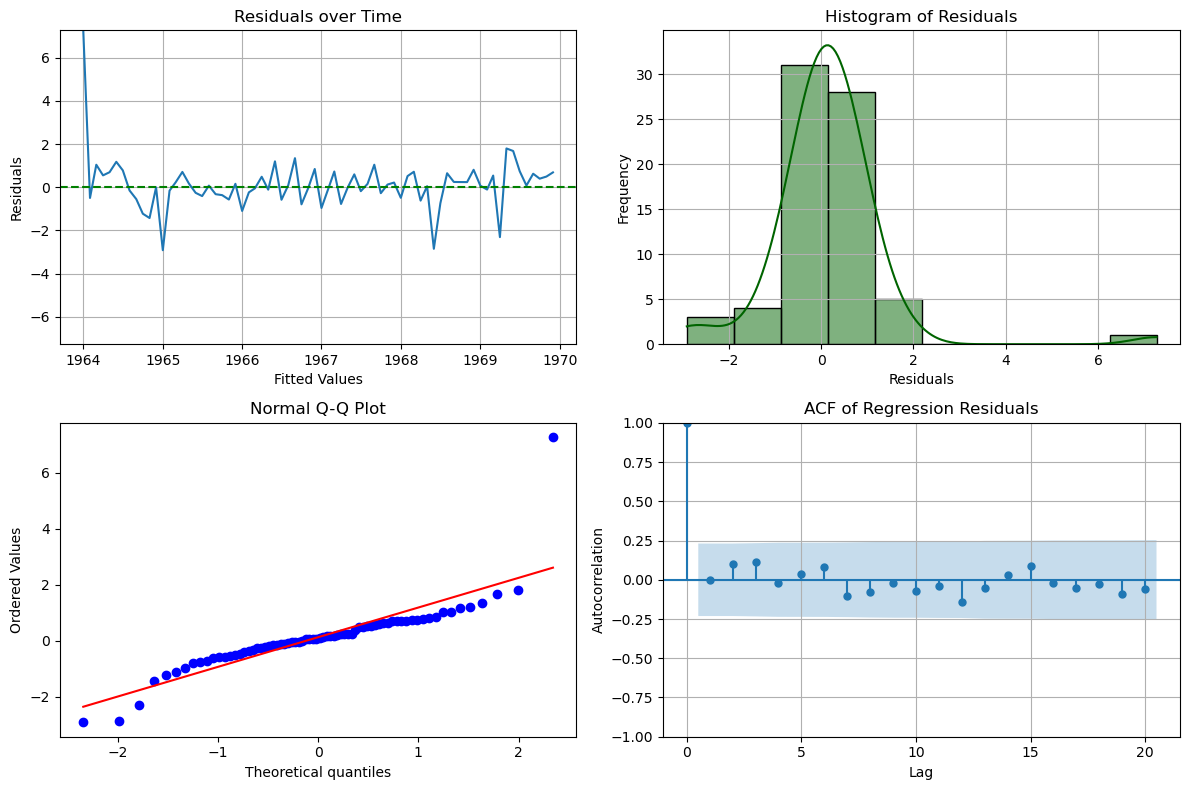

In [20]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_012.resid  

# Diagnostic plots for the model, including residuals and other model checks
#model_fit.plot_diagnostics(figsize=(10, 8));  

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Standardized Residuals
axes[0, 0].plot(residuals)
axes[0, 0].axhline(y=0, color='green', linestyle='--')          
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals over Time')
max_abs = abs(residuals).max()                     # Get max absolute residual
axes[0, 0].set_ylim(-max_abs, max_abs)             # Set symmetric limits
axes[0, 0].grid(True)

# 2. Histogram of Residuals
sns.histplot(residuals, bins=10, edgecolor='black', color='darkgreen', kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True)

# 3. Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Normal Q-Q Plot')
plt.grid(True)

# 4. Correlogram (ACF)
plot_acf(residuals, lags=20, ax=axes[1, 1])                    
axes[1, 1].set_title('ACF of Regression Residuals')
axes[1, 1].set_xlabel('Lag')
axes[1, 1].set_ylabel('Autocorrelation')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [21]:
# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.001155,0.972885
2,0.794013,0.672330
3,1.749788,0.625922
4,1.780921,0.775971
5,1.897661,0.863117
6,2.421078,0.877194
7,3.265923,0.859361
8,3.805430,0.874238
9,3.847683,0.921148
10,4.316129,0.931961


### Better!!!

In [22]:
# Forecast the next 12 time points
forecast_12m = model_fit_012.get_forecast(steps=12)

# Extract predicted mean and confidence intervals
forecast_mean_12 = forecast_12m.predicted_mean
conf_int_12 = forecast_12m.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast'] = forecast_mean_12.values                                # Forecast mean

test['Error'] = test['Forecast'] - test['Miles']

test['Lower 95% CI'] = conf_int_12.iloc[:, 0].values                      # Lower bound
test['Upper 95% CI'] = conf_int_12.iloc[:, 1].values                      # Upper bound

# Show the updated test DataFrame
test

,Miles,Forecast,Error,Lower 95% CI,Upper 95% CI
Month,,,,,
1970-01-01,10.840,10.406391,-0.433609,8.754716,12.058066
1970-02-01,10.436,9.979511,-0.456489,8.187903,11.771120
1970-03-01,13.589,12.372335,-1.216665,10.573531,14.171139
1970-04-01,13.402,10.825158,-2.576842,9.019187,12.631129
1970-05-01,13.103,12.965959,-0.137041,11.152850,14.779069
1970-06-01,14.933,13.720944,-1.212056,11.900724,15.541165
1970-07-01,14.147,13.305868,-0.841132,11.478564,15.133171
1970-08-01,14.057,14.367000,0.310000,12.532641,16.201359
1970-09-01,16.234,15.570250,-0.663750,13.728863,17.411638


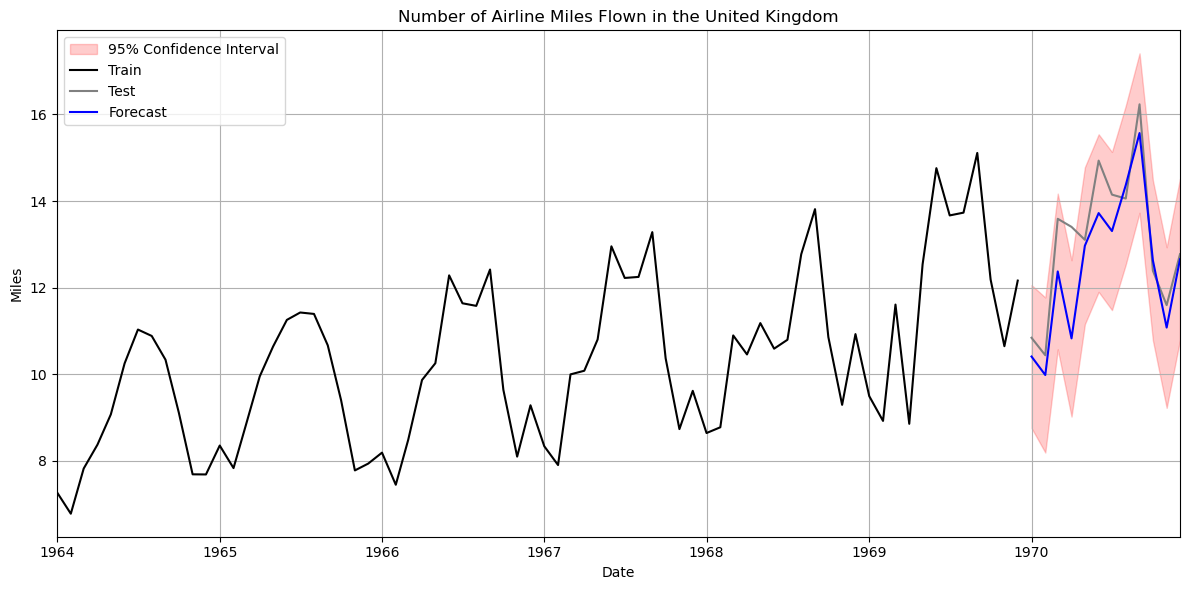

In [23]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_12.iloc[:, 0],     # Lower bound
                 conf_int_12.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['Miles'], label='Train', color='black')  # Train
plt.plot(test.index, test['Miles'], label='Test', color='gray')      # Test

plt.plot(test.index, test['Forecast'], label='Forecast', color='blue')    # Forecast

plt.title('Number of Airline Miles Flown in the United Kingdom')                      
plt.xlabel('Date')                                        
plt.ylabel('Miles')  
plt.xlim(pd.to_datetime('1964-01-01'), pd.to_datetime('1970-12-01'))
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

In [24]:
# Calculate MAPE
mape = (np.abs(test['Error']) / test['Miles']).mean() * 100

# Print the result
print(f"MAPE SARIMA(0,1,2)(1,1,0)[12] model: {mape:.2f}%")

MAPE SARIMA(0,1,2)(1,1,0)[12] model: 5.44%
